# Описание данных
train.csv
* msno: user id
* song_id: song id
* source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
* source_screen_name: name of the layout a user sees.
* source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
* target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .

test.csv
* id: row id (will be used for submission)
* msno: user id
* song_id: song id
* source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
* source_screen_name: name of the layout a user sees.
* source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.

sample_submission.csv
sample submission file in the format that we expect you to submit

* id: same as id in test.csv
* target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .

songs.csv
The songs. Note that data is in unicode.

* song_id
* song_length: in ms
* genre_ids: genre category. Some songs have multiple genres and they are separated by |
* artist_name
* composer
* lyricist
* language

members.csv
* user information.

* msno
* city
* bd: age. Note: this column has outlier values, please use your judgement.
* gender
* registered_via: registration method
* registration_init_time: format %Y%m%d
* expiration_date: format %Y%m%d

song_extra_info.csv
* song_id
* song name - the name of the song.
* isrc - International Standard Recording Code, theoretically can be used as an identity of a song. However, what worth to note is, ISRCs generated from providers have not been officially verified; therefore the information in ISRC, such as country code and reference year, can be misleading/incorrect. Multiple songs could share one ISRC since a single recording could be re-published several times.

Загрузка необходимых библиотек для работы

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

Загрузка данных

In [3]:
!rm -r ./data
!mkdir ./data/
!pip install gdown
!cd ./data && gdown --id '14WfNTraqMx3x_ad64iV2peezbYaEELuN' && unzip "kkbox-music-recommendation-challenge"
#https://drive.google.com/file/d/14WfNTraqMx3x_ad64iV2peezbYaEELuN/view?usp=sharing

rm: cannot remove './data': No such file or directory
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=14WfNTraqMx3x_ad64iV2peezbYaEELuN
From (redirected): https://drive.google.com/uc?id=14WfNTraqMx3x_ad64iV2peezbYaEELuN&confirm=t&uuid=b1e9599e-50f4-4f7b-a25c-eb4a94d48b1a
To: /content/data/kkbox-music-recommendation-challenge.zip
100% 741M/741M [00:09<00:00, 80.1MB/s]
Archive:  kkbox-music-recommendation-challenge.zip
  inflating: song_extra_info.csv     
  inflating: songs.csv               
  inflating: test.csv                
  inflating: train.csv               
  inflating: members.csv             
  inflating: sample_submission.csv   


In [4]:
train = pd.read_csv('/content/data/train.csv')
test = pd.read_csv('/content/data/test.csv')
songs = pd.read_csv('/content/data/songs.csv')
members = pd.read_csv('/content/data/members.csv')

#EDA

In [ ]:
train.head(5)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [ ]:
train.describe()

,target
count,7.377418e+06
mean,5.035171e-01
std,4.999877e-01
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   msno                object
 1   song_id             object
 2   source_system_tab   object
 3   source_screen_name  object
 4   source_type         object
 5   target              int64 
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


In [ ]:
train.isnull().sum()

msno                       0
song_id                    0
source_system_tab      24849
source_screen_name    414804
source_type            21539
target                     0
dtype: int64

In [ ]:
train['source_system_tab'].value_counts()

source_system_tab
my library      3684730
discover        2179252
search           623286
radio            476701
listen with      212266
explore          167949
notification       6185
settings           2200
Name: count, dtype: int64

In [ ]:
train['source_screen_name'].value_counts()

source_screen_name
Local playlist more     3228202
Online playlist more    1294689
Radio                    474467
Album more               420156
Search                   298487
Artist more              252429
Discover Feature         244246
Discover Chart           213658
Others profile more      201795
Discover Genre            82202
My library                75980
Explore                   72342
Unknown                   54170
Discover New              15955
Search Trends             13632
Search Home               13482
My library_Search          6451
Self profile more           212
Concert                      47
Payment                      12
Name: count, dtype: int64

In [ ]:
train['source_type'].value_counts()

source_type
local-library             2261399
online-playlist           1967924
local-playlist            1079503
radio                      483109
album                      477344
top-hits-for-artist        423614
song                       244722
song-based-playlist        210527
listen-with                192842
topic-article-playlist      11194
artist                       3038
my-daily-playlist             663
Name: count, dtype: int64

<Axes: xlabel='source_type', ylabel='count'>

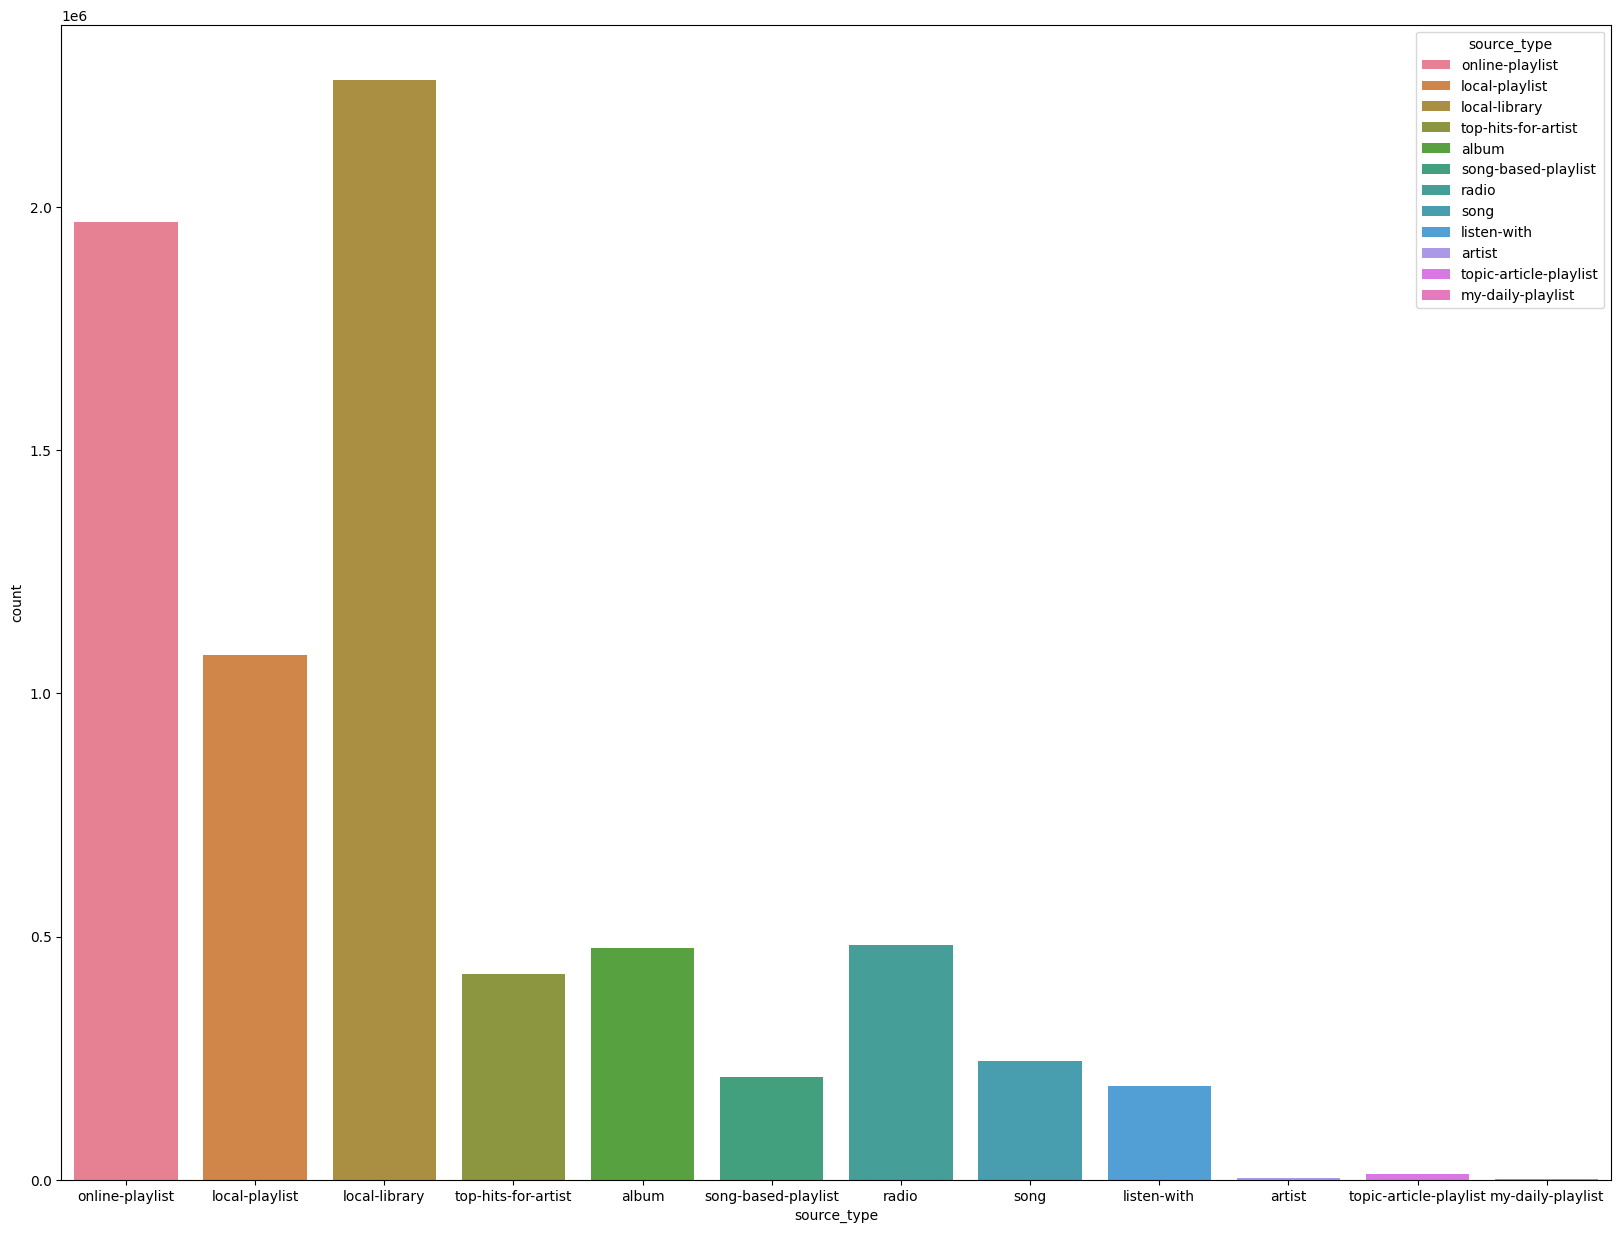

In [ ]:
#топ 3 места, где чаще всего слушают - онлайн плейлист, локальный плейлист и локальная библиотека.
plt.figure(figsize=(20,15))
sns.countplot(x='source_type',hue='source_type',data=train)

<Axes: xlabel='source_system_tab', ylabel='count'>

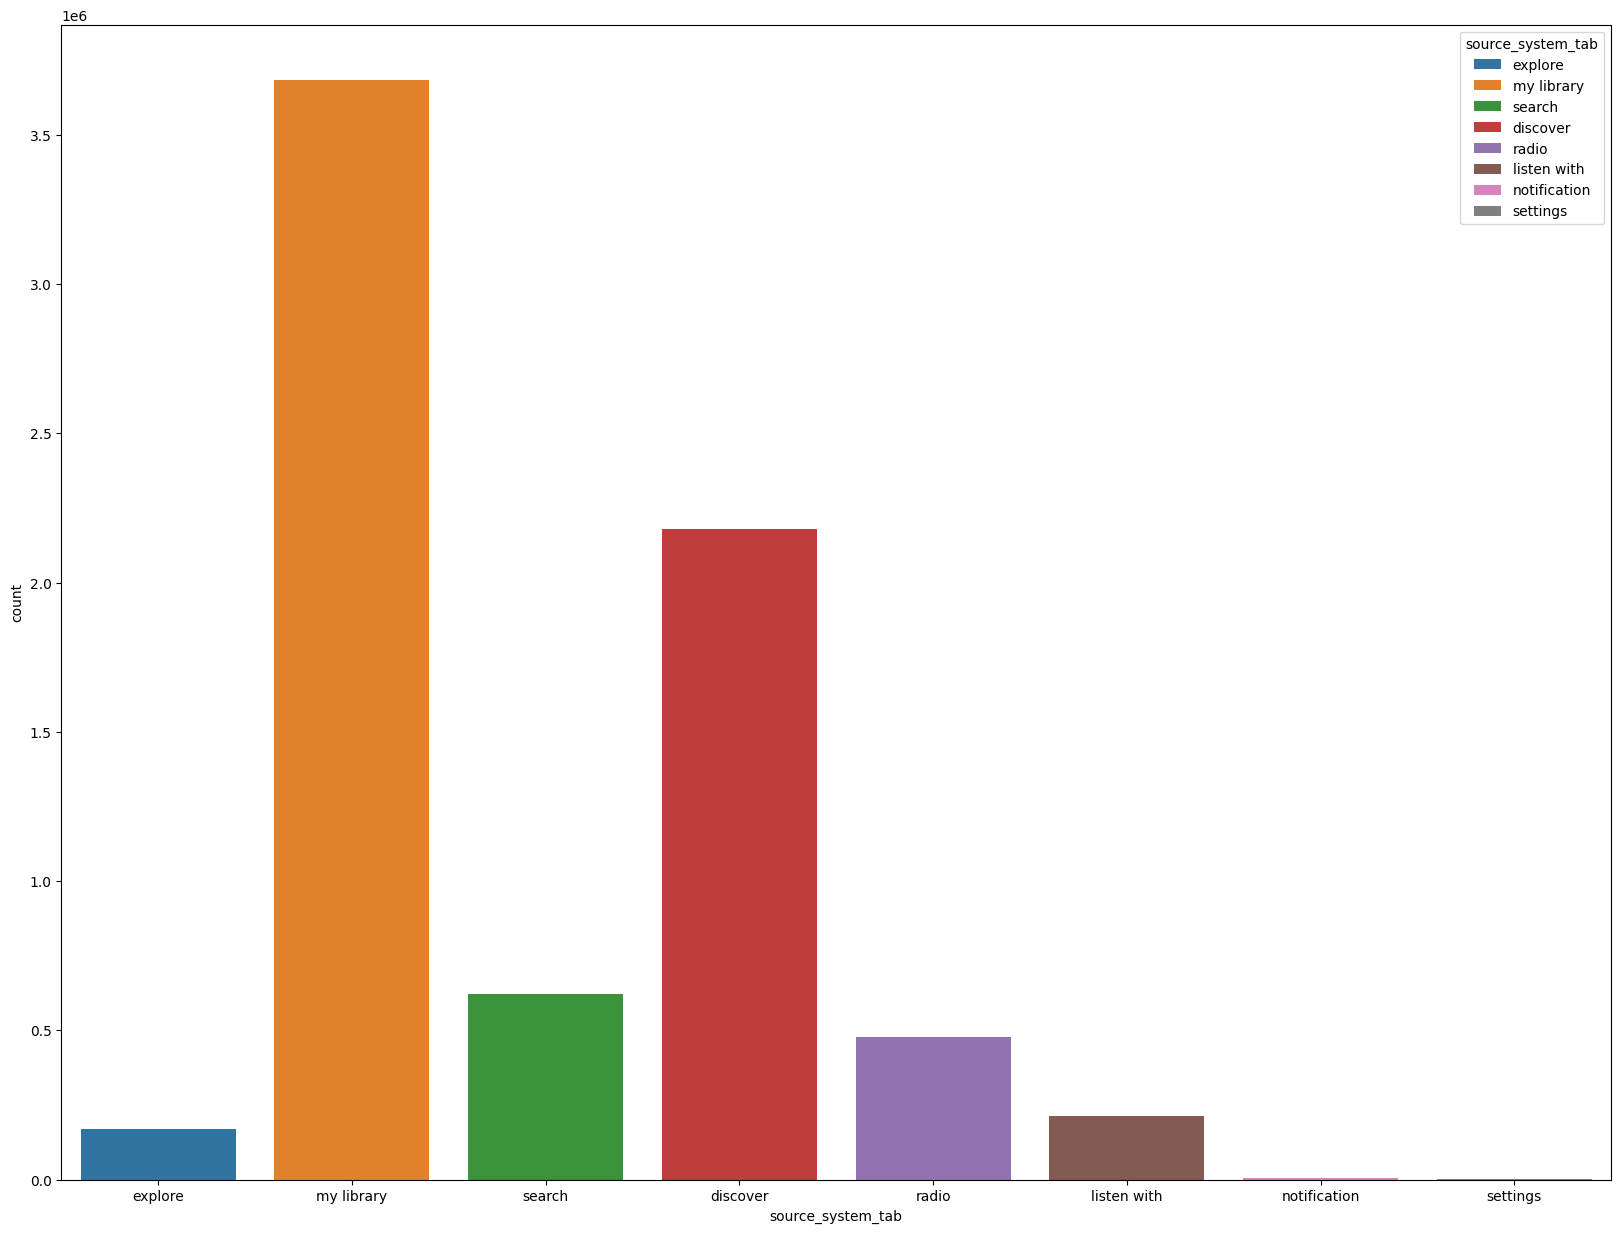

In [ ]:
#на первом месте - песни из личной библиотеки, что кажется логичным
plt.figure(figsize=(20,15))
sns.countplot(x='source_system_tab',hue='source_system_tab',data=train)

In [ ]:
test.head(5)

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [ ]:
test.describe()

,id
count,2.556790e+06
mean,1.278394e+06
std,7.380818e+05
min,0.000000e+00
25%,6.391972e+05
50%,1.278394e+06
75%,1.917592e+06
max,2.556789e+06


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   id                  int64 
 1   msno                object
 2   song_id             object
 3   source_system_tab   object
 4   source_screen_name  object
 5   source_type         object
dtypes: int64(1), object(5)
memory usage: 117.0+ MB


In [ ]:
test.isnull().sum()

id                         0
msno                       0
song_id                    0
source_system_tab       8442
source_screen_name    162883
source_type             7297
dtype: int64

In [ ]:
songs.head(5)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [ ]:
songs.describe()

,song_length,language
count,2.296320e+06,2.296319e+06
mean,2.469935e+05,3.237800e+01
std,1.609200e+05,2.433241e+01
min,1.850000e+02,-1.000000e+00
25%,1.836000e+05,-1.000000e+00
50%,2.266270e+05,5.200000e+01
75%,2.772690e+05,5.200000e+01
max,1.217385e+07,5.900000e+01


In [ ]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   song_id      object 
 1   song_length  int64  
 2   genre_ids    object 
 3   artist_name  object 
 4   composer     object 
 5   lyricist     object 
 6   language     float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


In [ ]:
songs.isnull().sum()

song_id              0
song_length          0
genre_ids        94116
artist_name          0
composer       1071358
lyricist       1945306
language             1
dtype: int64

In [ ]:
members.head(5)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [ ]:
members.describe()

,city,bd,registered_via,registration_init_time,expiration_date
count,34403.000000,34403.000000,34403.000000,3.440300e+04,3.440300e+04
mean,5.371276,12.280935,5.953376,2.013994e+07,2.016901e+07
std,6.243929,18.170251,2.287534,2.954015e+04,7.320925e+03
min,1.000000,-43.000000,3.000000,2.004033e+07,1.970010e+07
25%,1.000000,0.000000,4.000000,2.012103e+07,2.017020e+07
50%,1.000000,0.000000,7.000000,2.015090e+07,2.017091e+07
75%,10.000000,25.000000,9.000000,2.016110e+07,2.017093e+07
max,22.000000,1051.000000,16.000000,2.017023e+07,2.020102e+07


In [ ]:
members.info()
#отсутствуют значения в колонке гендера

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   msno                    34403 non-null  object
 1   city                    34403 non-null  int64 
 2   bd                      34403 non-null  int64 
 3   gender                  14501 non-null  object
 4   registered_via          34403 non-null  int64 
 5   registration_init_time  34403 non-null  int64 
 6   expiration_date         34403 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


([<matplotlib.patches.Wedge at 0x7ae800943340>,
 [Text(-0.03681225938151968, 1.0993838536012923, 'Male'),
  Text(0.03681225938151954, -1.0993838536012923, 'Female')],
 [Text(-0.02007941420810164, 0.5996639201461594, '51%'),
  Text(0.020079414208101564, -0.5996639201461594, '49%')])

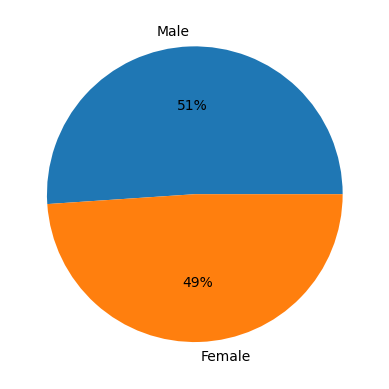

In [ ]:
#но в общем, мужчин чуть больше женщин, но нужно смотреть на корреляцию данных значений. Объединим все в один датафрейм для более легкой взаимодействии
plt.pie(pd.value_counts(members.gender), labels=['Male','Female'], autopct='%.0f%%',)

# Подготовка данных

Объединим датафреймы.
Можно попробовать учитывать метаданные об пользователях и песнях, чтобы выдавать получше рекомендации.

с train объединим songs и members по msno и songs_id

In [5]:
merged_data = pd.merge(train, songs, on='song_id', how='left')
merged_data = pd.merge(merged_data, members, on='msno', how='left')
merged_data.head(5)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,1,0,NaN,7,20120102,20171005


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   msno                    object 
 1   song_id                 object 
 2   source_system_tab       object 
 3   source_screen_name      object 
 4   source_type             object 
 5   target                  int64  
 6   song_length             float64
 7   genre_ids               object 
 8   artist_name             object 
 9   composer                object 
 10  lyricist                object 
 11  language                float64
 12  city                    int64  
 13  bd                      int64  
 14  gender                  object 
 15  registered_via          int64  
 16  registration_init_time  int64  
 17  expiration_date         int64  
dtypes: float64(2), int64(6), object(10)
memory usage: 1013.1+ MB


In [31]:
merged_data.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist', 'language', 'city', 'bd', 'gender',
       'registered_via', 'registration_init_time', 'expiration_date'],
      dtype='object')

In [ ]:
#merged_data['artist_name'].value_counts()#посмотреть, какие именно данные в колонках по отдельности и какие значения они принимают

Необходимо изменить типы данных, чтобы учить модели.

Надо избавиться от категориальных переменных.

Также не совсем понятно, как быть, например, со столбцом genre, тк там могут находиться несколько жанров, но для начала можно попробовать все закодировать с помощью LE

Конечно, все зависит от того, какую задачу мы решаем (хотим популяризировать еще неизвестные песни или выдавать популярные), тк колаб ограничен в памяти, то будем считать, что хотим выдавать популярные песни, что подходят пользователю

In [6]:
song_counts = merged_data['song_id'].value_counts()
single_values = song_counts[song_counts == 1]
single_value_indices = merged_data['song_id'].isin(single_values.index)
merged_data_no_singles = merged_data[~single_value_indices]
merged_data_no_singles.shape

(7210652, 18)

In [7]:
#уберем дублирование источника, оставим один
merged_data_no_singles = merged_data_no_singles.drop(['source_screen_name','source_type'], axis=1)

In [8]:
#удалим еще некоторые столбцы, которые скорее незначительные
merged_data_no_singles.drop(['song_length', 'bd', 'registered_via', 'registration_init_time', 'expiration_date'], axis = 1, inplace = True)

In [29]:
# genre_counts = merged_data_no_singles['genre_ids'].value_counts()
# mean_genre_counts = np.mean(genre_counts)

In [25]:
# #уберем песни, у которых жанры не встречаются часто
# single_values = genre_counts[genre_counts < mean_genre_counts]
# single_value_indices = merged_data_no_singles['genre_ids'].isin(single_values.index)
# merged_data_no_singles = merged_data_no_singles[~single_value_indices]
# merged_data_no_singles.shape

(7207855, 18)

In [9]:
#удаляем индексы песен, тк они больше не нужны
merged_data_no_singles.drop(['song_id'], axis = 1, inplace = True)

In [131]:
merged_data_no_singles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7210652 entries, 0 to 7377417
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   msno               object 
 1   source_system_tab  object 
 2   target             int64  
 3   genre_ids          object 
 4   artist_name        object 
 5   composer           object 
 6   lyricist           object 
 7   language           float64
 8   city               int64  
 9   gender             object 
dtypes: float64(1), int64(2), object(7)
memory usage: 605.1+ MB


In [132]:
merged_data_no_singles.isna().sum()

msno                       0
source_system_tab      24473
target                     0
genre_ids             113829
artist_name               82
composer             1600554
lyricist             3044549
language                 118
city                       0
gender               2891836
dtype: int64

In [10]:
#удалим столбцы, где неизвестных слишком много
merged_data_no_singles.drop(['composer','lyricist'], axis = 1, inplace = True)

In [11]:
from statistics import mode
numerical_cols = ['source_system_tab', 'language', 'city']
for col in numerical_cols:
    if merged_data_no_singles[col].dtype != 'object':
        merged_data_no_singles[col].fillna(mode(merged_data_no_singles[col]), inplace=True)

In [12]:
#в остальных заполним пропуски
merged_data_no_singles['source_system_tab'] = merged_data_no_singles['source_system_tab'].fillna('Unknown')
merged_data_no_singles['gender'] = merged_data_no_singles['gender'].fillna('Unknown')
merged_data_no_singles['genre_ids'] = merged_data_no_singles['genre_ids'].fillna(-1)
merged_data_no_singles['artist_name'] = merged_data_no_singles['artist_name'].fillna('Unknown')
print(merged_data_no_singles.isna().sum())

msno                 0
source_system_tab    0
target               0
genre_ids            0
artist_name          0
language             0
city                 0
gender               0
dtype: int64


In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Кодирование категориальных признаков
merged_data_no_singles['genre_ids'] = merged_data_no_singles['genre_ids'].astype('str')
merged_data_no_singles['genre_ids'] = le.fit_transform(merged_data_no_singles['genre_ids'])
merged_data_no_singles['gender'] = le.fit_transform(merged_data_no_singles['gender'])
merged_data_no_singles['artist_name'] = le.fit_transform(merged_data_no_singles['artist_name'])
merged_data_no_singles['msno'] = le.fit_transform(merged_data_no_singles['msno'])
# Создание новых столбцов с помощью метода dummies
data = pd.get_dummies(merged_data_no_singles, columns=['source_system_tab'])

In [137]:
data.head(5)

,msno,target,genre_ids,artist_name,language,city,gender,source_system_tab_Unknown,source_system_tab_discover,source_system_tab_explore,source_system_tab_listen with,source_system_tab_my library,source_system_tab_notification,source_system_tab_radio,source_system_tab_search,source_system_tab_settings
0,8153,1,225,1683,52.0,1,0,False,False,True,False,False,False,False,False,False
2,17246,1,67,10931,52.0,13,1,False,False,False,False,True,False,False,False,False
4,8153,1,3,2294,52.0,1,0,False,False,True,False,False,False,False,False,False
5,8153,1,67,4107,52.0,1,0,False,False,True,False,False,False,False,False,False
6,17246,1,269,1496,31.0,13,1,False,False,False,False,True,False,False,False,False


In [138]:
merged_data.shape#было

(7377418, 18)

In [139]:
data.shape#стало после ohe

(7210652, 16)

In [140]:
data.info()#старые типы

<class 'pandas.core.frame.DataFrame'>
Index: 7210652 entries, 0 to 7377417
Data columns (total 16 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   msno                            int64  
 1   target                          int64  
 2   genre_ids                       int64  
 3   artist_name                     int64  
 4   language                        float64
 5   city                            int64  
 6   gender                          int64  
 7   source_system_tab_Unknown       bool   
 8   source_system_tab_discover      bool   
 9   source_system_tab_explore       bool   
 10  source_system_tab_listen with   bool   
 11  source_system_tab_my library    bool   
 12  source_system_tab_notification  bool   
 13  source_system_tab_radio         bool   
 14  source_system_tab_search        bool   
 15  source_system_tab_settings      bool   
dtypes: bool(9), float64(1), int64(6)
memory usage: 502.0 MB


In [14]:
import pandas as pd

columns_to_convert = ['source_system_tab_Unknown', 'source_system_tab_discover', 'source_system_tab_explore', 'source_system_tab_listen with',
                      'source_system_tab_my library', 'source_system_tab_notification', 'source_system_tab_radio',
                      'source_system_tab_search', 'source_system_tab_settings']

data[columns_to_convert] = data[columns_to_convert].apply(lambda x: x.astype('float64'))

In [ ]:
#data.info()#новые типы данных

In [ ]:
import pandas as pd

# Создаем словарь, в котором каждому пользователю (msno) сопоставляем уникальный номер группы
user_to_group = {user: group for group, user in enumerate(data['msno'].unique())}

# Добавляем новую колонку 'group' в датафрейм 'merged_data_no_singles'
data['group'] = data['msno'].map(user_to_group)

# Сортируем датафрейм по колонке 'group'
sorted_merged_data = data.sort_values(by='group')

# Выводим отсортированный датафрейм
print(sorted_merged_data)


Разделим на трейн и тест

In [41]:
X = sorted_merged_data.drop('target', axis=1)  # features
y = sorted_merged_data['target']  # target

In [42]:
n_rows = data.shape[0]#берем длину датафрейма
n_test = int(n_rows * 0.3)#длина тестовых данных

#создаем индексы для трейна и теста
train_idx = range(n_rows - n_test)
test_idx = range(n_rows - n_test, n_rows)

In [43]:
import gc
gc.collect()

23

In [44]:
X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]
X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)#падает

Проведем нормализацию, чтобы перейти к обучению

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Раз категориальных переменных больше нет, то можно попробовать обучить модель
Так как изначально у нас бинарная переменная, то если решать чисто задачу классификации, то ничего отранжировать не получится. Поэтому можно выдавать вероятности, по которым можно будет потом отсортировать и посмотреть метрику для 20 релевантных (NDCG@20)

Руководствовалась этим примером: https://github.com/catboost/catboost/blob/master/catboost/tutorials/ranking/ranking_tutorial.ipynb

In [20]:
!pip install catboost

In [21]:
from catboost import CatBoostRanker, Pool, MetricVisualizer

In [32]:
parameters = {
    'iterations': 100,
    'custom_metric': ['NDCG'],
    'random_state': 42,
}

In [46]:
train_pool = Pool(data=X_train, label=y_train, group_id=sorted_merged_data['group'].iloc[train_idx])
test_pool = Pool(data=X_test, label=y_test, group_id=sorted_merged_data['group'].iloc[test_idx])


In [48]:
model = CatBoostRanker(**parameters)
model.fit(train_pool, eval_set=test_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.4740986	best: 0.4740986 (0)	total: 48.6s	remaining: 1h 20m 9s
1:	test: 0.4761778	best: 0.4761778 (1)	total: 1m 40s	remaining: 1h 21m 47s
2:	test: 0.4757355	best: 0.4761778 (1)	total: 2m 30s	remaining: 1h 21m 3s
3:	test: 0.4768335	best: 0.4768335 (3)	total: 3m 15s	remaining: 1h 18m 8s
4:	test: 0.4767933	best: 0.4768335 (3)	total: 4m 5s	remaining: 1h 17m 44s
5:	test: 0.4800863	best: 0.4800863 (5)	total: 4m 54s	remaining: 1h 16m 58s
6:	test: 0.4801378	best: 0.4801378 (6)	total: 5m 41s	remaining: 1h 15m 32s
7:	test: 0.4800330	best: 0.4801378 (6)	total: 6m 29s	remaining: 1h 14m 44s
8:	test: 0.4833898	best: 0.4833898 (8)	total: 7m 20s	remaining: 1h 14m 15s
9:	test: 0.4829845	best: 0.4833898 (8)	total: 8m 7s	remaining: 1h 13m 8s
10:	test: 0.4830021	best: 0.4833898 (8)	total: 8m 54s	remaining: 1h 12m 3s
11:	test: 0.4964063	best: 0.4964063 (11)	total: 9m 45s	remaining: 1h 11m 32s
12:	test: 0.4970686	best: 0.4970686 (12)	total: 10m 35s	remaining: 1h 10m 55s
13:	test: 0.4990342	best: 0